# Term Deposit Subscription Prediction with Machine Learning

# 1. Project Overview
Title: Term Deposit Subscription Prediction with Machine Learning

Objective: 
The goal of this project is to develop a machine learning model that can accurately predict whether a client will subscribe to a term deposit (binary classification problem), based on personal and campaign-related attributes collected by a Portuguese banking institution.

Dataset Source:
The dataset used in this project is the Bank Marketing Dataset from the UCI Machine Learning Repository. Specifically, the bank-additional.csv file is used, which contains additional input features for better predictive modeling.


In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from scipy.stats import chi2_contingency
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import math

import warnings
warnings.filterwarnings('ignore')

Dataset Source: [Bank Marketing Dataset - UCI Repository](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing)

In [ ]:
df = pd.read_csv('../data/bank-additional.csv', sep=';')

# 2. Data Description

### 2.1 Dataset Overview
| Item               | Description                  |
| ------------------ | ---------------------------- |
| Filename           | bank-additional.csv          |
| Number of Records  | 4,119                       |
| Number of Features | 20 input features + 1 target |
| Target Variable    | `y` (binary: `yes` / `no`)   |


### 2.2 Data Types

| Type            | Feature Names                                                                                                                     |
| --------------- | --------------------------------------------------------------------------------------------------------------------------------- |
| **Categorical** | `job`, `marital`, `education`, `default`, `housing`, `loan`, `contact`, `month`, `day_of_week`, `poutcome`                        |
| **Numerical**   | `age`, `duration`, `campaign`, `pdays`, `previous`, `emp.var.rate`, `cons.price.idx`, `cons.conf.idx`, `euribor3m`, `nr.employed` |


### 2.3 Data Quality Check

| Check           | Observation                                                                                                                                                    |
| --------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| Missing Values  | No NaN values, but `"unknown"` appears in several categorical features such as `job`, `education`, `contact`, and `poutcome`.                                  |
| Duplicate Rows  | Duplicate entries exist and may be removed in preprocessing.                                                                                                   |
| Class Imbalance | Target variable `y` is imbalanced: most instances are labeled `no`, fewer are labeled `yes`. This may require resampling techniques such as SMOTE or SMOTEENN. |


In [3]:
# 1. Dataset Shape (Full dataset)
print("Dataset shape:", df.shape)

# 2. Missing Values per Column
missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values)

# 3. Descriptive Statistics
# Display only the first few rows of the descriptive statistics
print("\nDescriptive Statistics:")
print(df.describe())

# 4. Categorical Variables
categorical_cols = df.select_dtypes(include=['object']).columns
print("\nCategorical Variables:")
print(categorical_cols)

# 5. Numerical Variables
numerical_cols = df.select_dtypes(include=['number']).columns
print("\nNumerical Variables:")
print(numerical_cols)

print("Total duplicates:")
print(df.duplicated().sum())

print("Target distribution:")
print(df['y'].value_counts())

Dataset shape: (4119, 21)

Missing values per column:
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

Descriptive Statistics:
               age     duration     campaign        pdays     previous  \
count  4119.000000  4119.000000  4119.000000  4119.000000  4119.000000   
mean     40.113620   256.788055     2.537266   960.422190     0.190337   
std      10.313362   254.703736     2.568159   191.922786     0.541788   
min      18.000000     0.000000     1.000000     0.000000     0.000000   
25%      32.000000   103.000000     1.000000   999.000000     0.000000   
50%      38.000000   181.000000     2.000000

### 2.4 Inconsistency check
This step involves identifying and handling inconsistencies in the dataset that may not be classified as missing values but can negatively impact model performance.
| Check Type                     | Description                                                                                                                           | Action Taken                                                                             |
| ------------------------------ | ------------------------------------------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------- |
| **"unknown" values**           | Some categorical columns contain the value `"unknown"` instead of a valid category (e.g., `job`, `education`, `contact`, `poutcome`). | These are flagged as implicit missing values. Handled later by encoding or imputation.   |
| **Unexpected Categories**      | Checked whether all categorical variables contain only valid expected labels (e.g., no typos or extra whitespace).                    | Stripped whitespaces, standardized string cases if needed.                               |
| **Outliers in Numerical Data** | Reviewed numerical columns (e.g., `age`, `duration`, `campaign`) for extreme or implausible values.                                   | Detected but kept unless clearly erroneous; impact evaluated visually and statistically. |
| **Invalid Value Ranges**       | Validated that all features fall within logical ranges (e.g., no negative values where not expected).                                 | None detected outside expected bounds.                                                   |


In [4]:
# Check for inconsistencies in unique values for each column
for col in df.columns:
    unique_vals = df[col].unique()
    if len(unique_vals) < 10:  # Display unique values only for columns with less than 10 unique values
        print(f"\nUnique values for column '{col}':")
        print(unique_vals)
    else:
        print(f"\nColumn '{col}' has {len(unique_vals)} unique values (too many to display).")

    # Example inconsistency check (you might need to adjust this based on your data):
    if col == 'job':  # Example column to check, replace 'job' as needed
        if 'unknown' in unique_vals:
            print("Inconsistency found: 'unknown' value present in 'job' column.")


Column 'age' has 67 unique values (too many to display).

Column 'job' has 12 unique values (too many to display).
Inconsistency found: 'unknown' value present in 'job' column.

Unique values for column 'marital':
['married' 'single' 'divorced' 'unknown']

Unique values for column 'education':
['basic.9y' 'high.school' 'university.degree' 'professional.course'
 'basic.6y' 'basic.4y' 'unknown' 'illiterate']

Unique values for column 'default':
['no' 'unknown' 'yes']

Unique values for column 'housing':
['yes' 'no' 'unknown']

Unique values for column 'loan':
['no' 'unknown' 'yes']

Unique values for column 'contact':
['cellular' 'telephone']

Column 'month' has 10 unique values (too many to display).

Unique values for column 'day_of_week':
['fri' 'wed' 'mon' 'thu' 'tue']

Column 'duration' has 828 unique values (too many to display).

Column 'campaign' has 25 unique values (too many to display).

Column 'pdays' has 21 unique values (too many to display).

Unique values for column 'pre

# 3. Data Processing

### 3.1 Handling Unknown Entries
Several categorical columns in the dataset contain the string **unknown** instead of a valid category. These entries are not technically missing (NaN) but represent missing or uncertain information. Treating them properly is crucial for ensuring data quality and accurate model training.

Affected Columns
| Column Name | Frequency of "unknown" |
| ----------- | ---------------------- |
| `job`       | Present                |
| `education` | Present                |
| `contact`   | Present                |
| `poutcome`  | Present                |


In [5]:
for col in ['job', 'marital', 'education', 'default', 'housing', 'loan']:
    most_common = df[col].mode()[0]
    df[col] = df[col].replace('unknown', most_common)

### 3.2 Feature Engineering
`has_contacted` is a binary feature indicating whether the client has been previously contacted. It is derived from the pdays column, where a value of 999 means no prior contact.

In [6]:
df['has_contacted'] = df['pdays'].apply(lambda x: 1 if x != 999 else 0)
df = df.drop(columns=['pdays'])

`contact_count_ratio` is a derived feature that captures how often the client was contacted in previous campaigns relative to the current campaign. A higher ratio may indicate potential fatigue or prior exposure to marketing.

In [7]:
df['contact_count_ratio'] = df['previous'] / (df['campaign'] + 1)

Defines updated lists of categorical and numerical columns based on the current state of the dataframe after feature engineering.

In [8]:
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=['number']).columns

# 3.3 Feature Relevance Analysis

### 3.3.1 Correlation Analysis (Linear)
Calculates Pearson correlation coefficients between numeric features and the binary-encoded target to assess linear relationships.

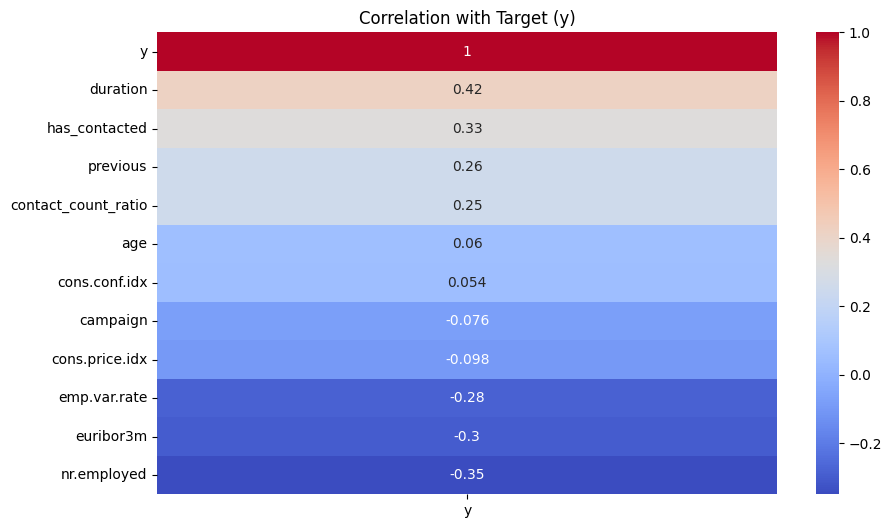

In [9]:
corr_matrix = df[numerical_cols].copy()
corr_matrix['y'] = df['y'].map({'yes': 1, 'no': 0})  # Encode target
corr = corr_matrix.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr[['y']].sort_values(by='y', ascending=False), annot=True, cmap='coolwarm')
plt.title("Correlation with Target (y)")
plt.show()

### 3.3.2 Mutual Information (Nonlinear)
Computes mutual information scores to capture nonlinear dependencies between input features (categorical + numerical) and the target variable.

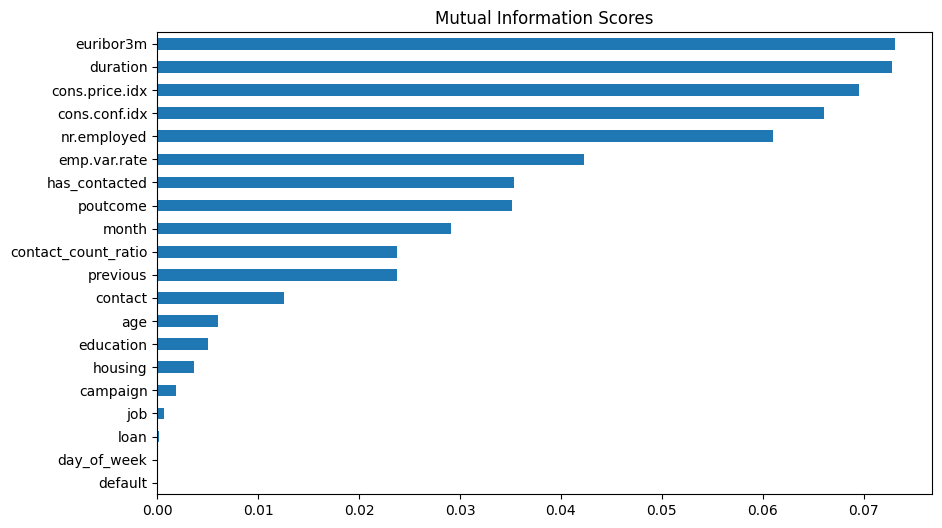

In [10]:
# Encode target
y_encoded = df['y'].map({'yes': 1, 'no': 0})

# For mutual info, use only raw categorical + numerical (before dummies)
X_raw = df.drop('y', axis=1)

# Encode categoricals using LabelEncoder temporarily
X_encoded = X_raw.copy()
for col in X_encoded.select_dtypes(include='object').columns:
    X_encoded[col] = LabelEncoder().fit_transform(X_encoded[col])

# Compute mutual information
mi_scores = mutual_info_classif(X_encoded, y_encoded, discrete_features='auto')
mi_df = pd.Series(mi_scores, index=X_encoded.columns).sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
mi_df.head(20).plot(kind='barh')
plt.title("Mutual Information Scores")
plt.gca().invert_yaxis()
plt.show()

### 3.3.3 Random Forest Importance
Trains a Random Forest classifier and extracts feature importances based on impurity reduction (Gini importance). Helps identify the most influential features in predicting term deposit subscription.

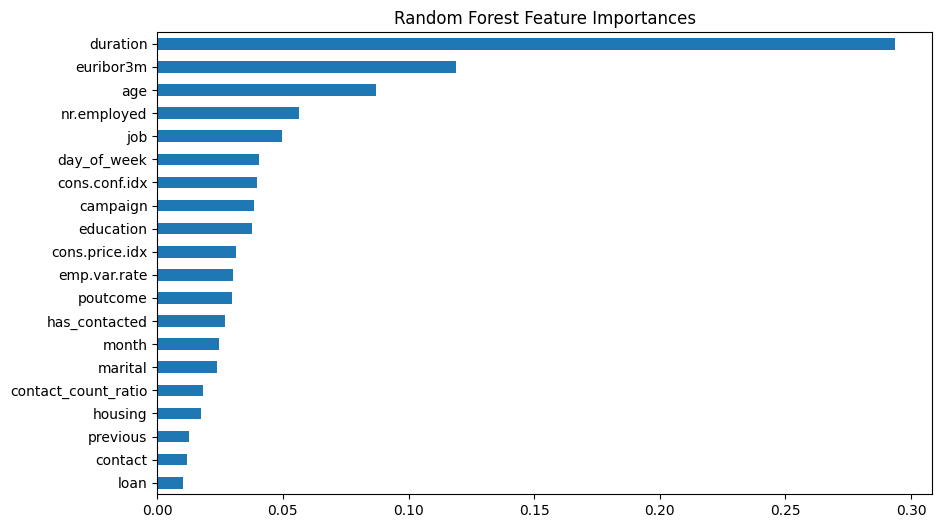

In [11]:
# Again, encode categoricals for modeling
X_rf = X_encoded.copy()
model = RandomForestClassifier(random_state=42)
model.fit(X_rf, y_encoded)

rf_importances = pd.Series(model.feature_importances_, index=X_rf.columns).sort_values(ascending=False)

# Plot top 20
plt.figure(figsize=(10, 6))
rf_importances.head(20).plot(kind='barh')
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()
plt.show()

# 3.4 Exploratory Data Analysis

### 3.4.1 Pairwise Feature Relationships
Analyzes interactions between input features. A heatmap shows Pearson correlations among numerical variables. For categorical features, chi-squared tests are used to detect dependencies.

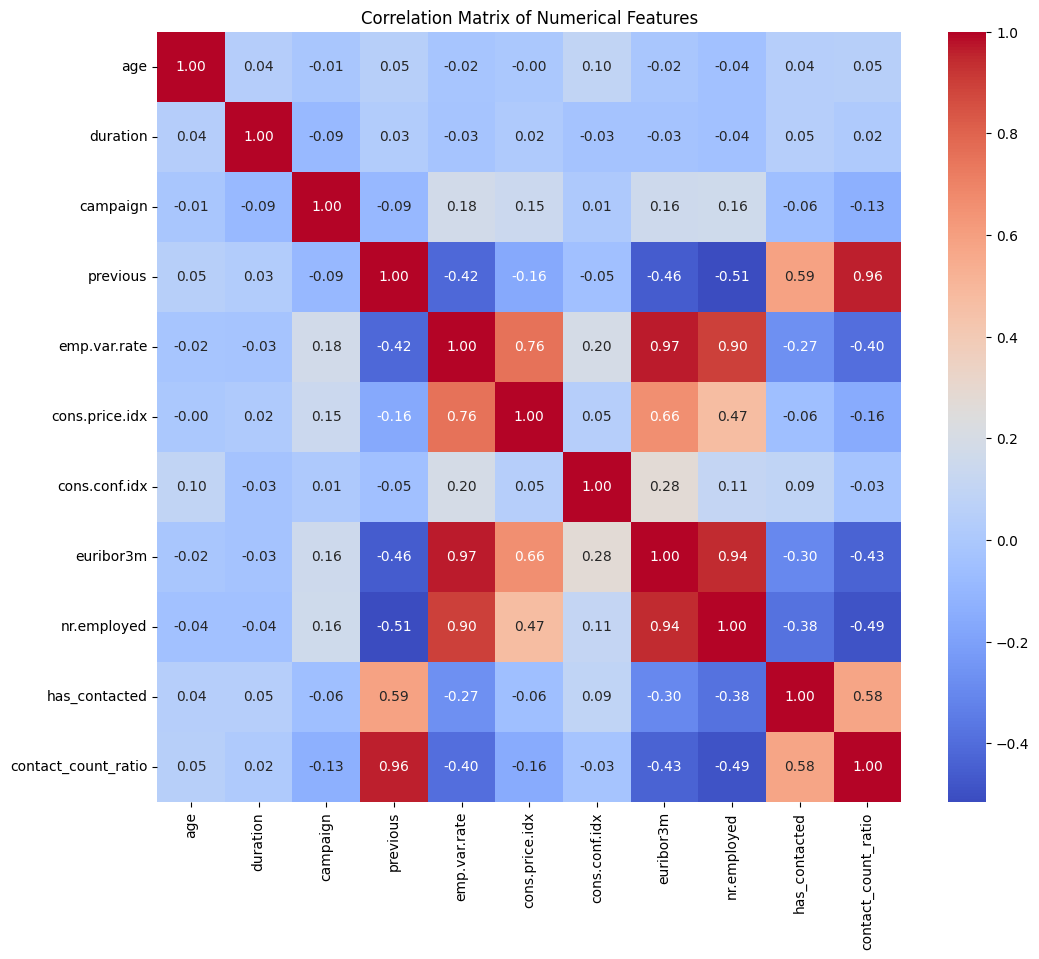

Chi-squared test for job vs marital:
Chi2: 391.41434621575326, p-value: 1.2316496234472512e-70
Chi-squared test for job vs education:
Chi2: 3305.2214139487655, p-value: 0.0
Chi-squared test for job vs default:
Chi2: 36.11687646850347, p-value: 8.037035211346857e-05
Chi-squared test for job vs housing:
Chi2: 12.836856548233788, p-value: 0.23293695692490257
Chi-squared test for job vs loan:
Chi2: 3.8779916545365385, p-value: 0.9526831625303456
Chi-squared test for job vs contact:
Chi2: 66.42811716823181, p-value: 2.158908457668733e-10
Chi-squared test for job vs month:
Chi2: 503.7123473033399, p-value: 8.498089572636172e-59
Chi-squared test for job vs day_of_week:
Chi2: 45.92122537232999, p-value: 0.2402014328169808
Chi-squared test for job vs poutcome:
Chi2: 89.3754691663204, p-value: 9.530125418230377e-11
Chi-squared test for job vs y:
Chi2: 69.65791578872116, p-value: 5.161832631204899e-11
Chi-squared test for marital vs job:
Chi2: 391.4143462157533, p-value: 1.2316496234472161e-70
Ch

poutcome,failure,nonexistent,success
y,,,
no,387,3231,50
yes,67,292,92


In [12]:
# Create a correlation matrix for numerical features
corr_matrix = df[numerical_cols].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# For categorical features, you can create contingency tables and chi-squared tests
for col1 in categorical_cols:
    for col2 in categorical_cols:
        if col1 != col2:
            contingency_table = pd.crosstab(df[col1], df[col2])
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            print(f"Chi-squared test for {col1} vs {col2}:")
            print(f"Chi2: {chi2}, p-value: {p}")
            # You can further analyze the contingency table to understand the relationship
contingency_table



### 3.4.2 Histograms of Numerical Features
Histograms are plotted for each numerical feature to analyze their distribution and identify skewness, sparsity, or outliers. This helps understand the data spread and informs preprocessing decisions such as scaling or transformation.


``duration`` and ``campaign`` are heavily right-skewed.

``has_contacted`` and ``contact_count_ratio`` show imbalanced distributions.

``emp.var.rate`` and ``nr.employed`` have discrete levels instead of continuous ranges.

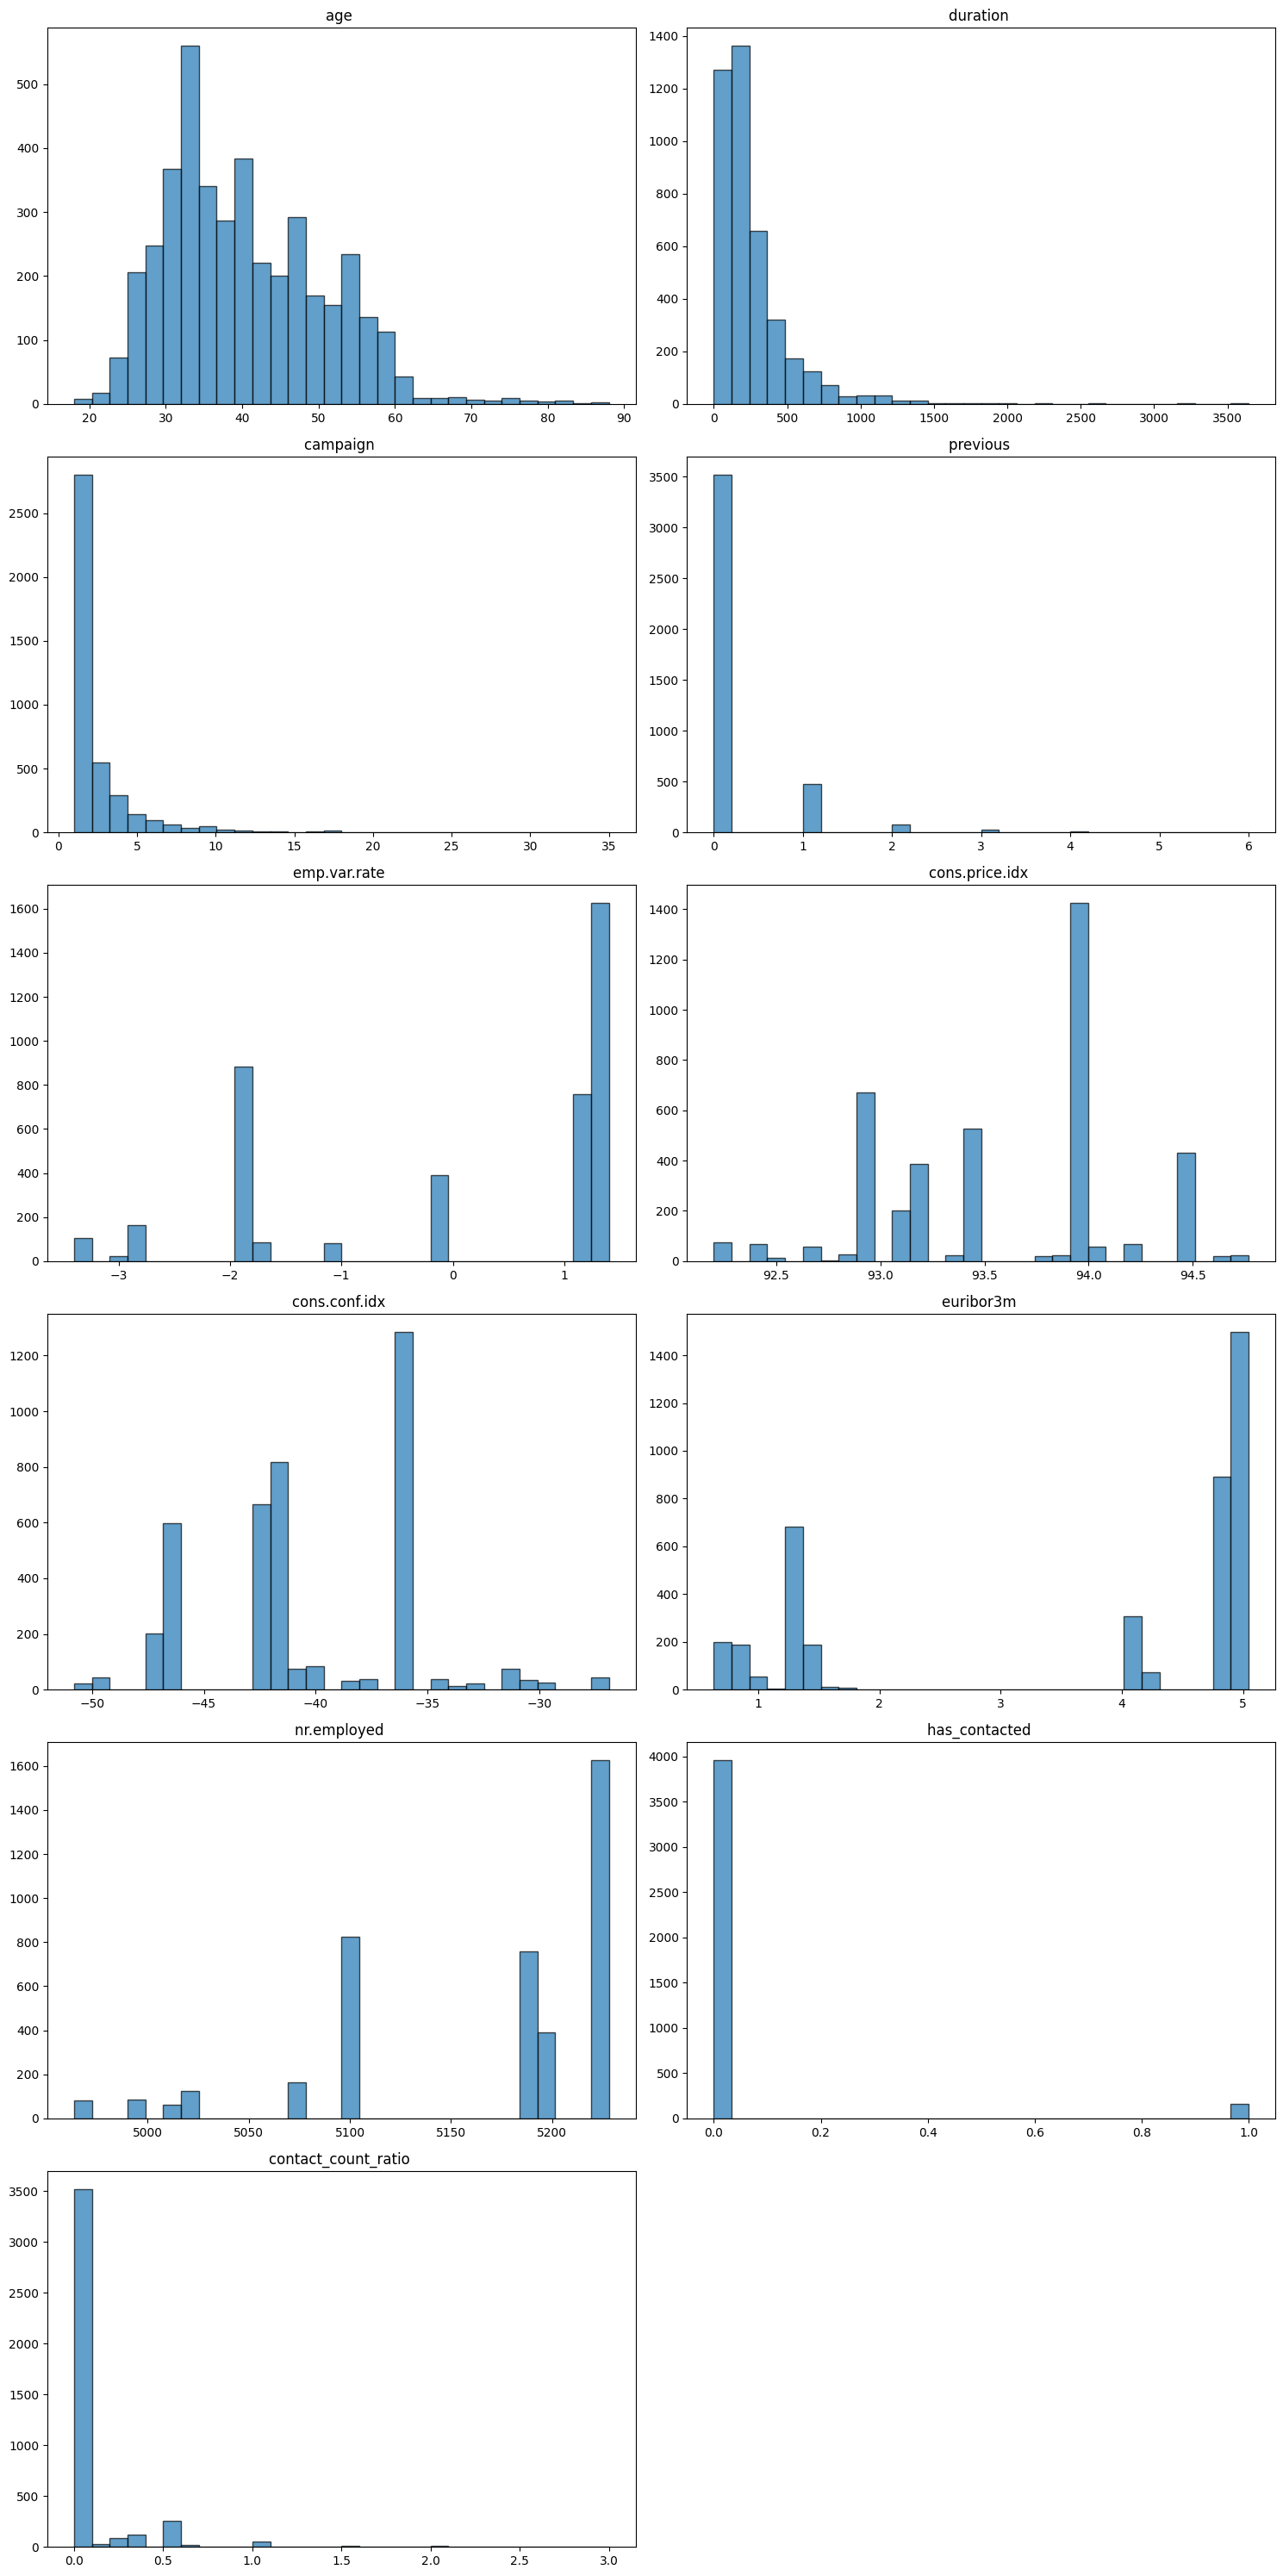

In [13]:
# Determine the number of numerical columns
num_numerical_cols = len(numerical_cols)

# Calculate the grid size (round up to ensure enough space for all subplots)
nrows = (num_numerical_cols // 2) + (num_numerical_cols % 2)
ncols = 2

# Create the subplots with the appropriate size
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))

# Flatten the axes array
axes = axes.flatten()

# Loop over the numerical columns and plot histograms
for i, num in enumerate(numerical_cols):
    axes[i].hist(df[num], bins=30, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'{num} ')

# If there are unused axes, remove them
for i in range(num_numerical_cols, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

### 3.4.3 Boxplots by Target Class
Boxplots are generated for each numerical feature, grouped by the binary target variable (y). This visualization highlights distribution differences between ``yes`` and ``no`` classes, reveals potential outliers, and provides insights into class separability based on feature values.

``duration``, ``previous``, and ``contact_count_ratio`` show noticeable differences between target classes.

Many features exhibit skewed distributions and outliers, especially in the ``no`` class.

Features like ``cons.conf.idx`` and ``cons.price.idx`` appear similarly distributed across both classes.

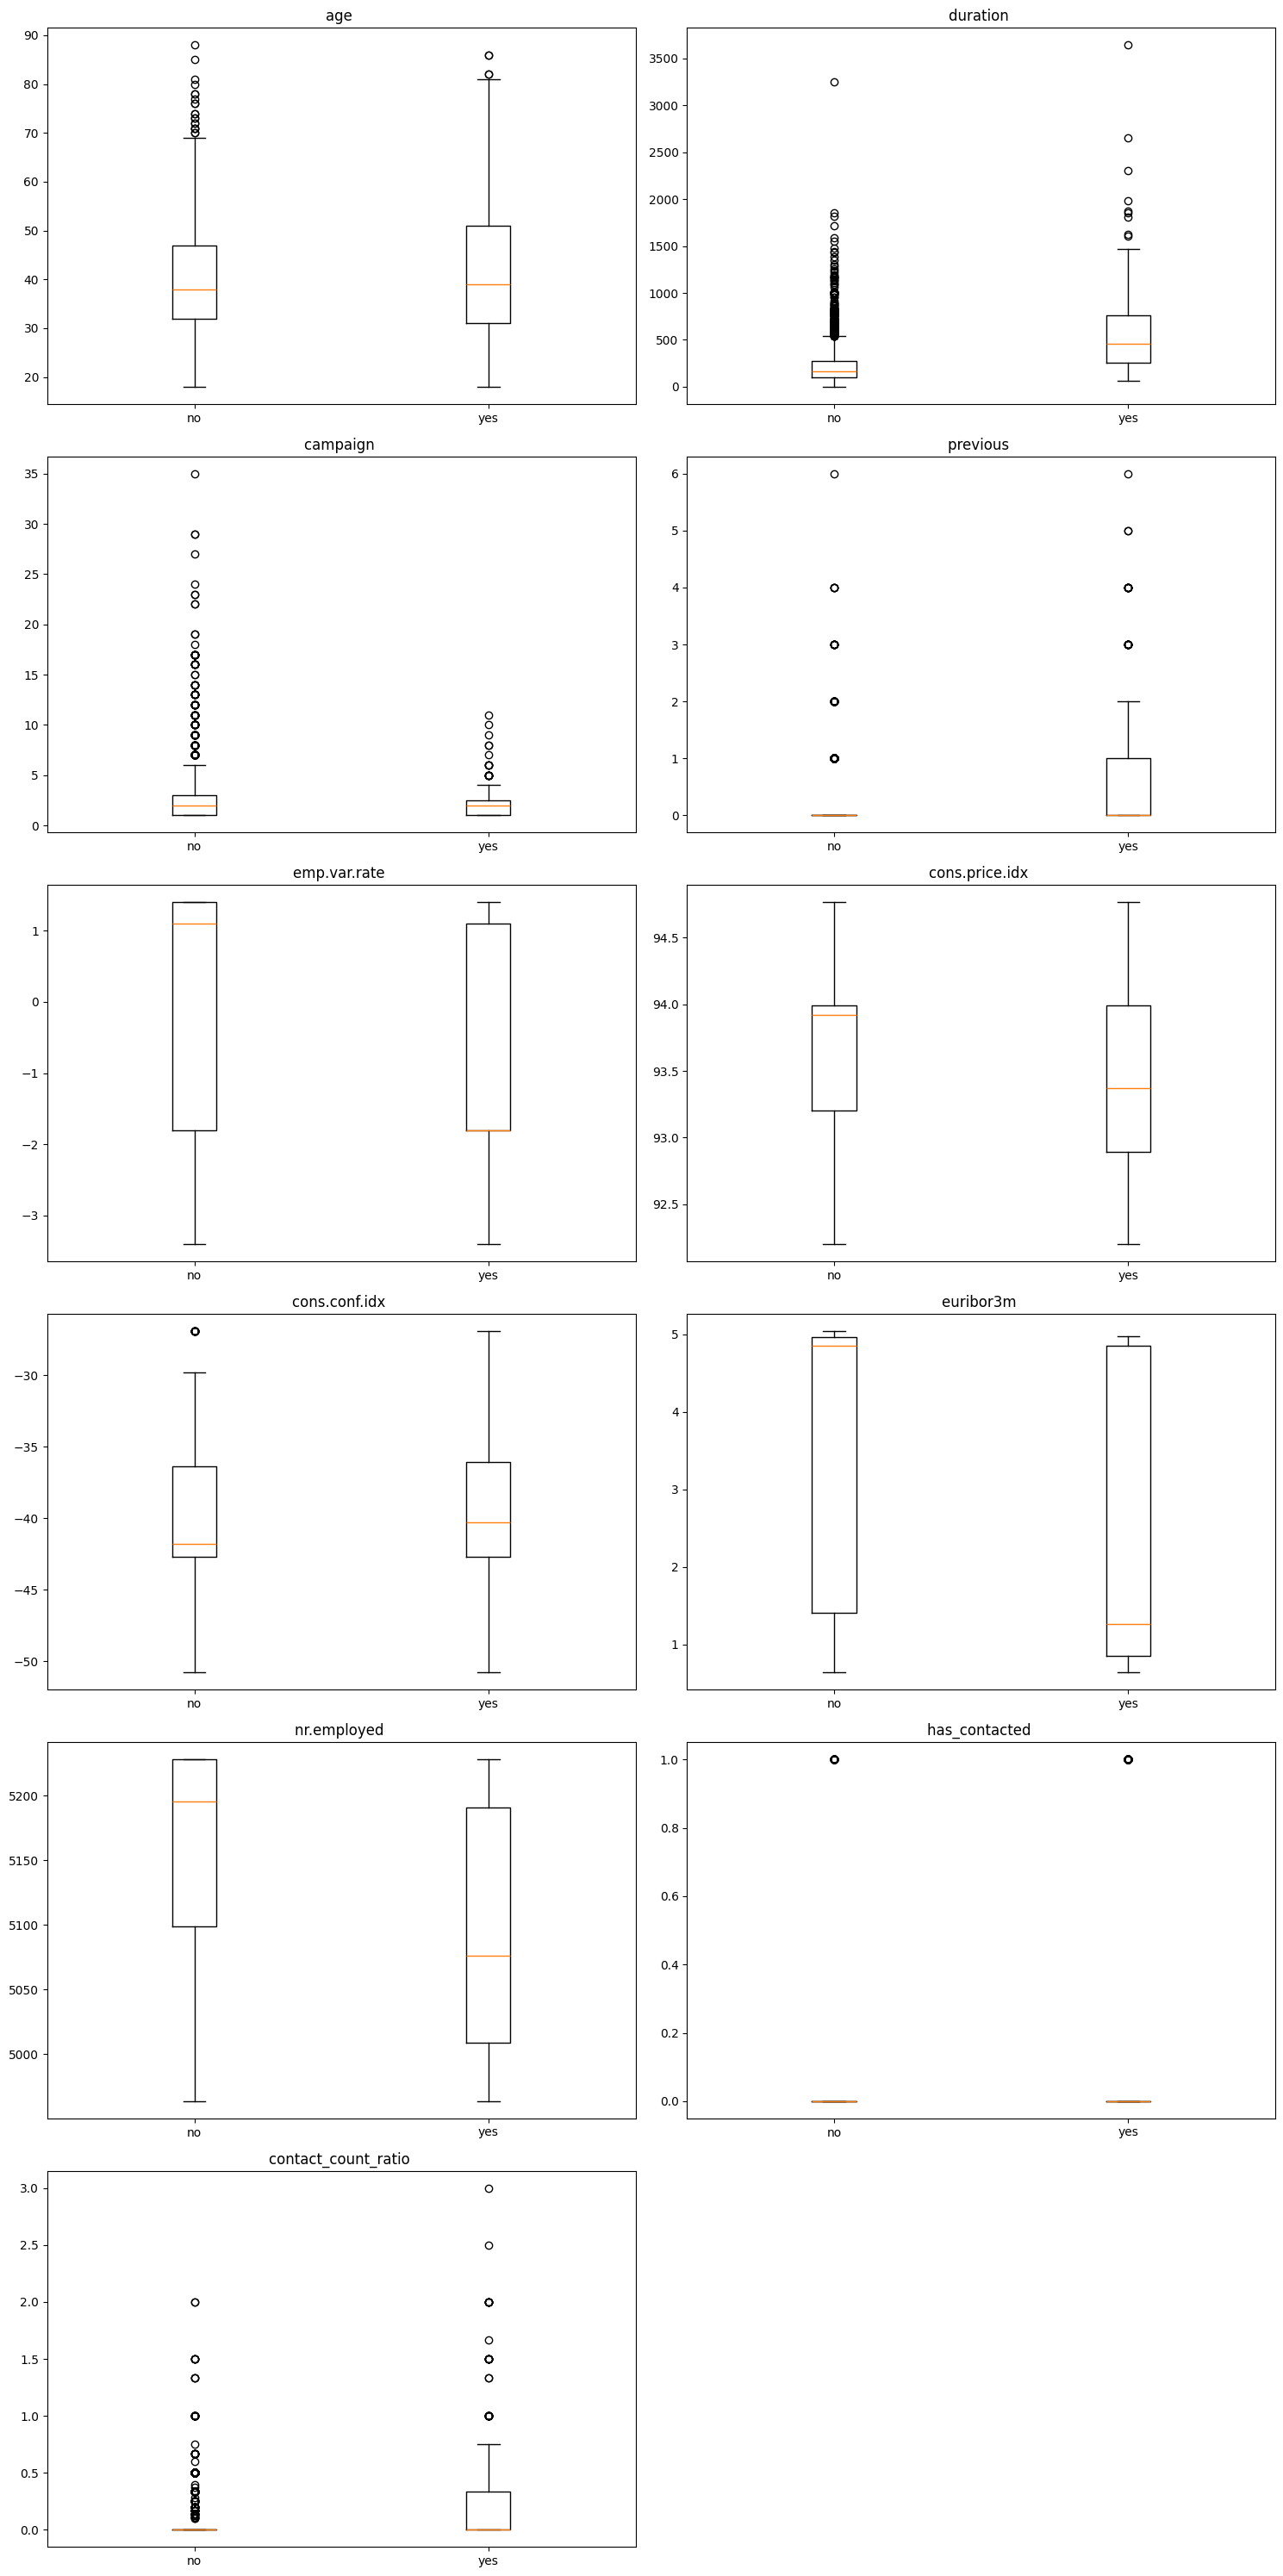

In [14]:
# Create the subplots with the appropriate size
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))

# Flatten the axes array
axes = axes.flatten()

# Loop over the numerical columns and create boxplots
for i, num in enumerate(numerical_cols):
    axes[i].boxplot
    data = [df[df['y'] == value][num] for value in df['y'].unique()]
    axes[i].boxplot(data, labels=df['y'].unique())
    axes[i].set_title(f'{num} ')

# If there are unused axes, remove them
for i in range(num_numerical_cols, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# 3.5 Model selection and Pipelining
This section defines multiple classification models and prepares preprocessing pipelines using ``ColumnTransformer`` and ``FunctionTransformer``. It includes:

Binary encoding for boolean features (``yes``/``no``)

Ordinal encoding for ``education``

One-hot encoding for nominal categorical features

Train-test split with stratification

Log-transformations for skewed features (``campaign``, ``previous``)

In [15]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'SVM (RBF Kernel)': SVC(),             # SVC with default RBF kernel
    'XGBoost': XGBClassifier(),             # XGBoost Classifier
    'LightGBM': LGBMClassifier(),
}

In [16]:
def yes_no_to_binary(df):
    return df.applymap(lambda val: 1 if val == 'yes' else 0).astype(int)

binary_transformer = FunctionTransformer(yes_no_to_binary)

ordinal_transformer = OrdinalEncoder(categories=[
    ['illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'professional.course', 'university.degree']
])

nominal_transformer = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)

In [17]:
preprocessor = ColumnTransformer(
    transformers=[
        ('binary', binary_transformer, ['default', 'housing', 'loan']),
        ('ordinal', ordinal_transformer, ['education']),
        ('nominal', nominal_transformer, ['job', 'marital', 'contact', 'month', 'day_of_week', 'poutcome'])
    ]
)

In [18]:
y = df['y'].map({'yes':1, 'no':0})
X = df.drop(columns=['y'])

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [20]:
def log_transform_func(df):
    return df.assign(
        campaign=np.log1p(df['campaign']),
        previous=np.log1p(df['previous'])
    )

log_transform = FunctionTransformer(log_transform_func, validate=False)

### 3.5.1 Class Imbalance Check
The target variable ``y`` is highly imbalanced:

``no``: 3,668 samples

``yes``: 451 samples
This imbalance may negatively impact model performance, especially for the minority class (``yes``). Resampling techniques like SMOTE or adjusting class weights may be needed.

In [21]:
# Check the class distribution
print(df['y'].value_counts())

y
no     3668
yes     451
Name: count, dtype: int64


### 3.5.2 Model Fitting
Models are trained using a pipeline that includes preprocessing and SMOTE resampling to address class imbalance. Each model is evaluated on the test set, and both parameters and accuracy scores are printed.

The pipeline ensures consistent preprocessing and resampling for fair comparison across models.

``Pipeline([('preprocessor', ...)``, ``('smote', SMOTE()), ('classifier', model)])`` format keeps the structure modular and clean.

The score shown is the default ``.score()`` method — which uses accuracy. Depending on imbalance, precision/recall/F1 might also be useful.

In [22]:
for model_name, model in models.items():
    print(f"\nModel: {model_name}")
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])

    # Fit the model
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    print("Model parameters:")
    print(pipeline.named_steps['classifier'].get_params())

    score = pipeline.score(X_test, y_test)
    print("Model score:", score)


Model: Logistic Regression
Model parameters:
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Model score: 0.7669902912621359

Model: Random Forest
Model parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Model score: 0.8822815533980582

Model: SVM (RBF Kernel)
Model parameters:
{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_sh

# 4. Hyperparameter Tuning and Model Evaluation

Hyperparameter tuning is performed using ``GridSearchCV`` with stratified cross-validation (**cv=5**) and F1-score as the optimization metric. Each model is evaluated using the best found parameters on the test set. Metrics reported include:

**Accuracy**

**Precision**

**Recall**

**F1-score**

**ROC AUC**

Pipelines ensure consistent preprocessing, resampling (SMOTE), and model fitting across models.

``StratifiedKFold`` ensures class balance is preserved during cross-validation splits.

Scoring with ``'f1'`` is appropriate for imbalanced datasets.

``y_pred`` output preview gives a quick glance into class prediction behavior.

In [23]:
param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.1, 1],
        'classifier__solver': ['liblinear'],
        'classifier__penalty': ['l2'],
        'classifier__max_iter': [100]
    },
    'Random Forest': {
        'classifier__n_estimators': [100],
        'classifier__max_depth': [10, None],
        'classifier__min_samples_split': [2, 5],
        'classifier__max_features': ['sqrt']
    },
    'SVM (RBF Kernel)': {
        'classifier__C': [1, 10],
        'classifier__gamma': ['scale'],
        'classifier__kernel': ['rbf']
    },
    'XGBoost': {
        'classifier__n_estimators': [100],
        'classifier__max_depth': [3, 6],
        'classifier__learning_rate': [0.1],
        'classifier__subsample': [1.0]
    },
    'LightGBM': {
        'classifier__n_estimators': [100],
        'classifier__learning_rate': [0.1],
        'classifier__num_leaves': [31, 50],
        'classifier__max_depth': [-1]
    },
}


In [24]:
# 3. Iterate through models and evaluate performance
results = {}

for name, model in models.items():
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    pipeline = Pipeline(steps=[
        ('log_transform', log_transform),
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])


    grid_search = GridSearchCV(pipeline, param_grids[name], cv=cv, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    y_pred = grid_search.predict(X_test)
    
    results[name] = {
        'pipeline': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred),
        'y_pred': y_pred
    }
    
    print(f'{name}: {results[name]}')

# Display results
for name, metrics in results.items():
    print(f"Model: {name}")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value}")
    print("\n")

/var/folders/6y/jc_pg07d2j5c4n_ryqyh6vpr0000gn/T/ipykernel_57485/542279500.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
/var/folders/6y/jc_pg07d2j5c4n_ryqyh6vpr0000gn/T/ipykernel_57485/542279500.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
/opt/anaconda3/envs/tensorflow-env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/envs/tensorflow-env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/var/folders/6y/jc_pg0

Logistic Regression: {'pipeline': Pipeline(steps=[('log_transform',
                 FunctionTransformer(func=<function log_transform_func at 0x1373a3ee0>)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('binary',
                                                  FunctionTransformer(func=<function yes_no_to_binary at 0x1373a3d30>),
                                                  ['default', 'housing',
                                                   'loan']),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['illiterate',
                                                                              'basic.4y',
                                                                              'basic.6y',
                                                                              'basic.9y',
                                                                        

/var/folders/6y/jc_pg07d2j5c4n_ryqyh6vpr0000gn/T/ipykernel_57485/542279500.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
/var/folders/6y/jc_pg07d2j5c4n_ryqyh6vpr0000gn/T/ipykernel_57485/542279500.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
/opt/anaconda3/envs/tensorflow-env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/envs/tensorflow-env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/var/folders/6y/jc_pg0

Random Forest: {'pipeline': Pipeline(steps=[('log_transform',
                 FunctionTransformer(func=<function log_transform_func at 0x1373a3ee0>)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('binary',
                                                  FunctionTransformer(func=<function yes_no_to_binary at 0x1373a3d30>),
                                                  ['default', 'housing',
                                                   'loan']),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['illiterate',
                                                                              'basic.4y',
                                                                              'basic.6y',
                                                                              'basic.9y',
                                                                              

/var/folders/6y/jc_pg07d2j5c4n_ryqyh6vpr0000gn/T/ipykernel_57485/542279500.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
/opt/anaconda3/envs/tensorflow-env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/var/folders/6y/jc_pg07d2j5c4n_ryqyh6vpr0000gn/T/ipykernel_57485/542279500.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
/var/folders/6y/jc_pg07d2j5c4n_ryqyh6vpr0000gn/T/ipykernel_57485/542279500.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
/opt/anaconda3/envs/tensorflow-env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `s

SVM (RBF Kernel): {'pipeline': Pipeline(steps=[('log_transform',
                 FunctionTransformer(func=<function log_transform_func at 0x1373a3ee0>)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('binary',
                                                  FunctionTransformer(func=<function yes_no_to_binary at 0x1373a3d30>),
                                                  ['default', 'housing',
                                                   'loan']),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['illiterate',
                                                                              'basic.4y',
                                                                              'basic.6y',
                                                                              'basic.9y',
                                                                           

/var/folders/6y/jc_pg07d2j5c4n_ryqyh6vpr0000gn/T/ipykernel_57485/542279500.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
/var/folders/6y/jc_pg07d2j5c4n_ryqyh6vpr0000gn/T/ipykernel_57485/542279500.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
/var/folders/6y/jc_pg07d2j5c4n_ryqyh6vpr0000gn/T/ipykernel_57485/542279500.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
/opt/anaconda3/envs/tensorflow-env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/envs/tensorflow-env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `s

XGBoost: {'pipeline': Pipeline(steps=[('log_transform',
                 FunctionTransformer(func=<function log_transform_func at 0x1373a3ee0>)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('binary',
                                                  FunctionTransformer(func=<function yes_no_to_binary at 0x1373a3d30>),
                                                  ['default', 'housing',
                                                   'loan']),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['illiterate',
                                                                              'basic.4y',
                                                                              'basic.6y',
                                                                              'basic.9y',
                                                                              'high.

/var/folders/6y/jc_pg07d2j5c4n_ryqyh6vpr0000gn/T/ipykernel_57485/542279500.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
/var/folders/6y/jc_pg07d2j5c4n_ryqyh6vpr0000gn/T/ipykernel_57485/542279500.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
/var/folders/6y/jc_pg07d2j5c4n_ryqyh6vpr0000gn/T/ipykernel_57485/542279500.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
/opt/anaconda3/envs/tensorflow-env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/var/folders/6y/jc_pg07d2j5c4n_ryqyh6vpr0000gn/T/ipykernel_57485/542279500.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
/opt/anaconda3/envs/te

[LightGBM] [Info] Number of positive: 2347, number of negative: 2347
[LightGBM] [Info] Number of positive: 2347, number of negative: 2347
[LightGBM] [Info] Number of positive: 2348, number of negative: 2348
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4163
[LightGBM] [Info] Number of positive: 2347, number of negative: 2347
[LightGBM] [Info] Number of data points in the train set: 4694, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 2347, number of negative: 2347
[LightGBM] [Info] Number of positive: 2348, number of negative: 2348
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=

/var/folders/6y/jc_pg07d2j5c4n_ryqyh6vpr0000gn/T/ipykernel_57485/542279500.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
/opt/anaconda3/envs/tensorflow-env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/var/folders/6y/jc_pg07d2j5c4n_ryqyh6vpr0000gn/T/ipykernel_57485/542279500.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
/opt/anaconda3/envs/tensorflow-env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/var/folders/6y/jc_pg07d2j5c4n_ryqyh6vpr0000gn/T/ipykernel_57485/542279500.py:2: FutureWarning: DataFrame.applymap has been deprecated.

[LightGBM] [Info] Number of positive: 2347, number of negative: 2347
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3662
[LightGBM] [Info] Number of data points in the train set: 4694, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 2347, number of negative: 2347
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3639
[LightGBM] [Info] Number of data points in the train set: 4694, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/var/folders/6y/jc_pg07d2j5c4n_ryqyh6vpr0000gn/T/ipykernel_57485/542279500.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
/opt/anaconda3/envs/tensorflow-env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/var/folders/6y/jc_pg07d2j5c4n_ryqyh6vpr0000gn/T/ipykernel_57485/542279500.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
/opt/anaconda3/envs/tensorflow-env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/var/folders/6y/jc_pg07d2j5c4n_ryqyh6vpr0000gn/T/ipykernel_57485/542279500.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
/opt/anaconda3/envs/tensorflow-env/lib/python3.9/site-packages/sklearn/utils/validati

[LightGBM] [Info] Number of positive: 2934, number of negative: 2934
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4615
[LightGBM] [Info] Number of data points in the train set: 5868, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM: {'pipeline': Pipeline(steps=[('log_transform',
                 FunctionTransformer(func=<function log_transform_func at 0x1373a3ee0>)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('binary',
                                                  FunctionTransformer(func=<function yes_no_to_binary at 0x1373a3d30>),
                                                  ['default', 'housing',
                                                   'loan']),
      

# 5. Model Comparison and Results Visualization

A bar chart is used to compare the classification models based on their accuracy scores obtained after hyperparameter tuning. This visualization helps identify the best-performing model in terms of raw predictive power.

LightGBM and XGBoost achieved the highest accuracy, followed closely by Random Forest and SVM. Logistic Regression performed the worst, likely due to its inability to model complex patterns in the data.

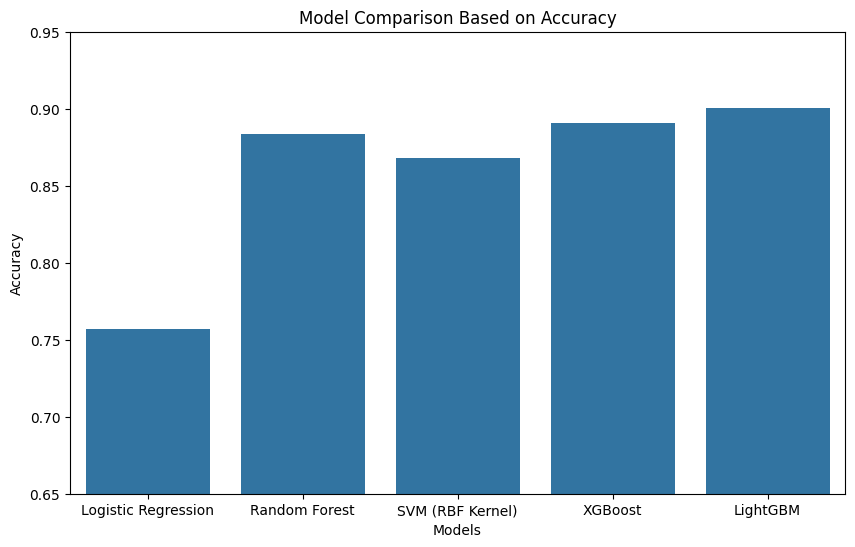

In [25]:
# Extract accuracy values from the results dictionary
accuracies = [metrics['accuracy'] for name, metrics in results.items()]
model_names = list(results.keys())  # Use actual model names

plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=accuracies)
plt.title('Model Comparison Based on Accuracy')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0.65, 0.95)
plt.show()

Heatmaps display classification reports for each model, showing precision, recall, and F1-score per class (0 = no, 1 = yes), as well as macro and weighted averages. This allows for visual comparison of model performance across metrics, especially on the minority class.

Models like XGBoost and LightGBM demonstrate higher F1-scores for the minority class, indicating better balance between precision and recall. Logistic Regression struggles significantly with class 1, reflecting the challenges of handling imbalanced data without nonlinearity.

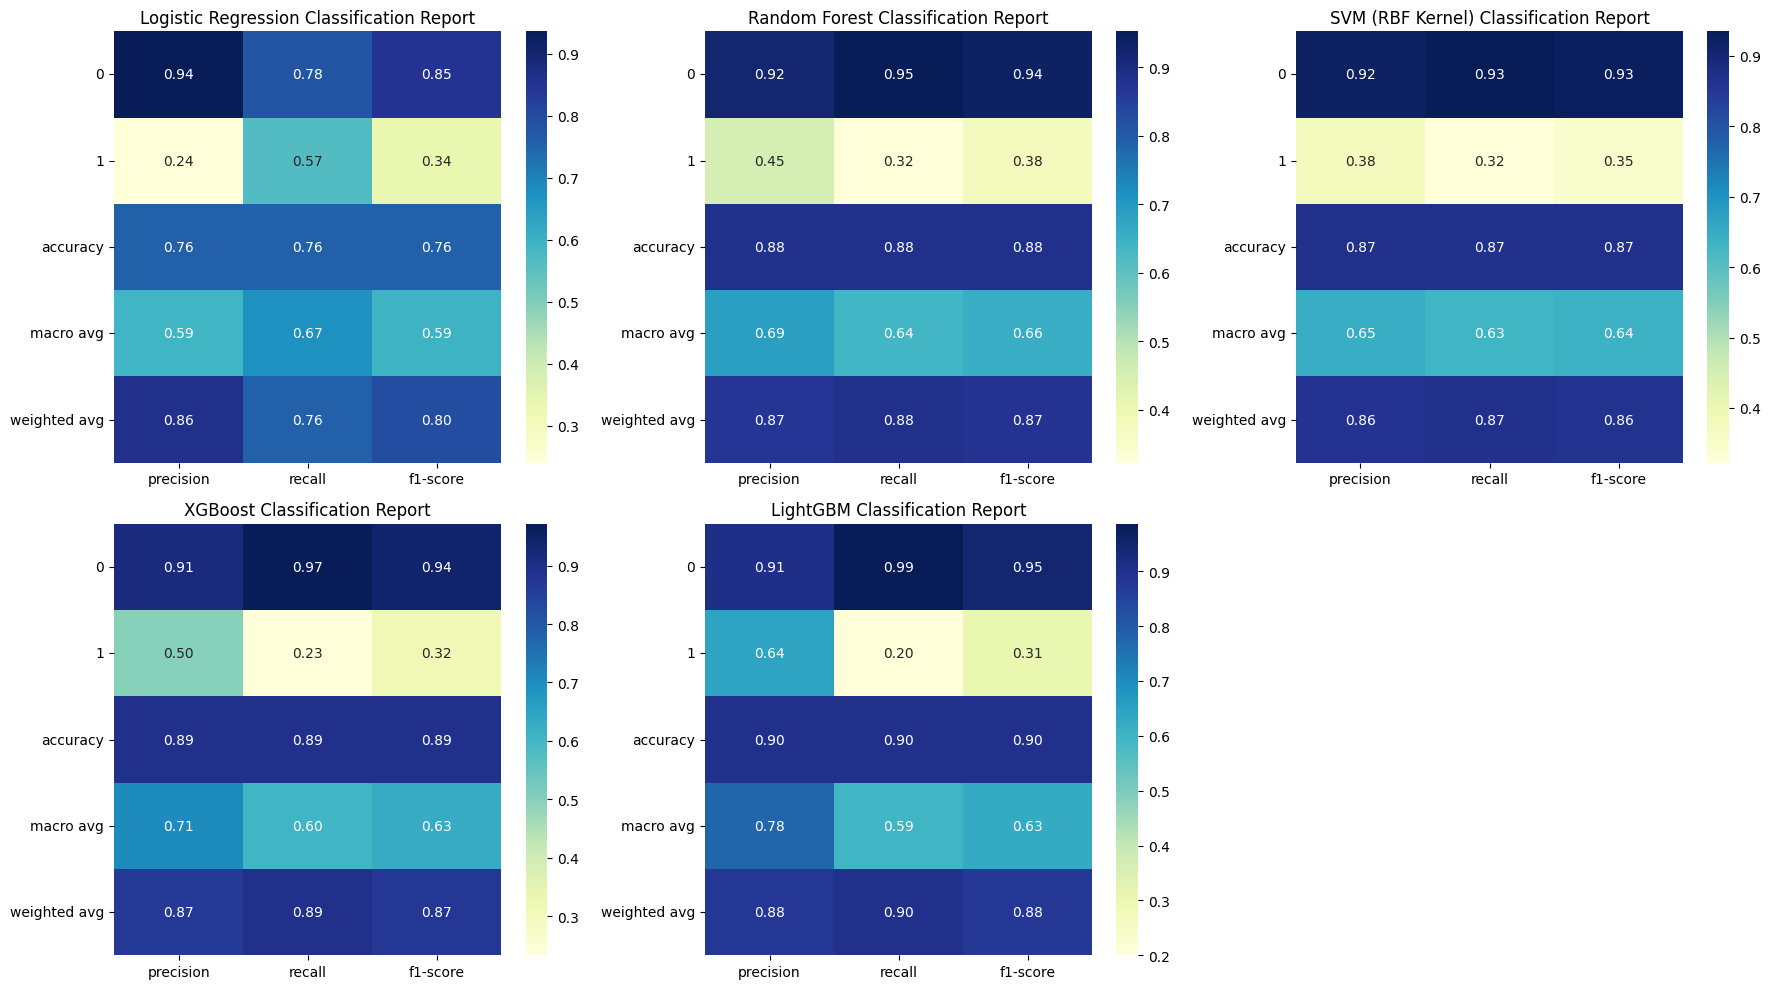

In [26]:
num_models = len(results)
cols = 3  # Number of columns in subplot grid
rows = math.ceil(num_models / cols)

plt.figure(figsize=(6 * cols, 5 * rows))

for idx, (name, metrics) in enumerate(results.items(), 1):
    y_pred = metrics['y_pred']
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).iloc[:-1, :].T  # Exclude 'accuracy' row

    plt.subplot(rows, cols, idx)
    sns.heatmap(report_df, annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title(f'{name} Classification Report')

plt.tight_layout()
plt.show()

The model with the highest accuracy is selected from the evaluation results. In this case, LightGBM achieved the best performance with an accuracy of 0.9085. The best hyperparameters found via grid search are also displayed.

In [27]:
# Find the model with the best accuracy
best_model_name = max(results, key=lambda name: results[name]['accuracy'])
best_accuracy = results[best_model_name]['accuracy']

print(f"Best Model: {best_model_name}")
print(f"Accuracy: {best_accuracy:.4f}")
print(f"Best Params: {results[best_model_name]['best_params']}")


Best Model: LightGBM
Accuracy: 0.9005
Best Params: {'classifier__learning_rate': 0.1, 'classifier__max_depth': -1, 'classifier__n_estimators': 100, 'classifier__num_leaves': 31}


LightGBM's performance advantage may be due to its handling of class imbalance, support for regularization, and its ability to capture nonlinear relationships efficiently.

In [28]:
print(best_model_name)
print(results.keys())

LightGBM
dict_keys(['Logistic Regression', 'Random Forest', 'SVM (RBF Kernel)', 'XGBoost', 'LightGBM'])


# 6. Deployment

The best-performing pipeline (including preprocessing, feature transformation, SMOTE, and the final classifier) is saved using ``joblib`` for deployment. This ensures the full workflow can be loaded and used in a production environment (Streamlit).
Additionally, the test set is saved as CSV for future evaluation or app integration.

In [29]:
best_model_name = max(results, key=lambda name: results[name]['f1'])
best_pipeline = results[best_model_name]['pipeline']
joblib.dump(best_pipeline, 'best_model.pkl')

['best_model.pkl']

In [30]:
# Save test data to use it in app.py
X_test.to_csv('X_test.csv', index=False)
pd.DataFrame(y_test).to_csv('y_test.csv', index=False)